<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Построим модель для такого предсказания со значением метрики RMSE не более 48.

## Подготовка

In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose

from catboost import CatBoostRegressor

import xgboost as xgb

from statsmodels.tsa.arima.model import ARIMA

In [2]:
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
df

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
df.isna().sum()

num_orders    0
dtype: int64

In [6]:
df.sort_index(inplace=True) 
df = df.resample('1H').sum()

Ресемплируем данные по одному часу

In [7]:
df['rolling_mean'] = df.rolling(2).mean()

Добавим скользяшее среднее

## Анализ

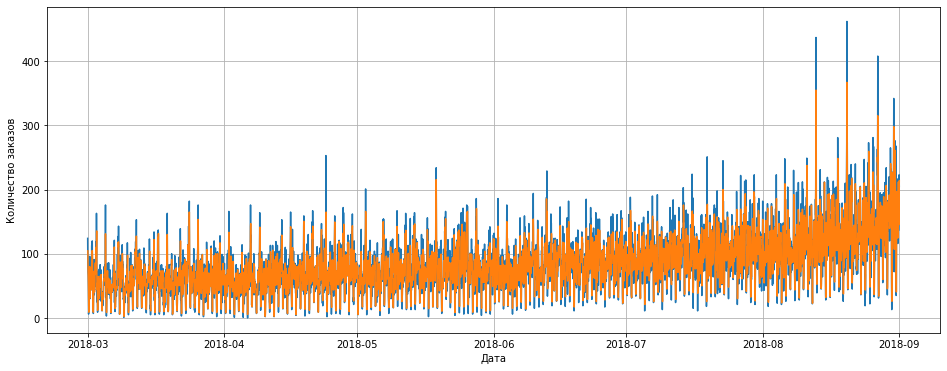

In [8]:
plt.figure(figsize=(16, 6))
plt.plot(df)
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.grid(True)
plt.show()

Выведем получившийся график

По графику можно сделать вывод о том, что тренд восходящий, к сентябрю 2018 года количество заказов выросло практически в 4 раза по сравнению с минимумом, который был достигнут в марте того же года. 

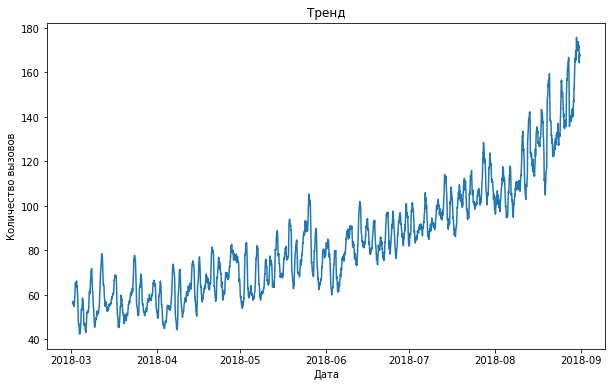

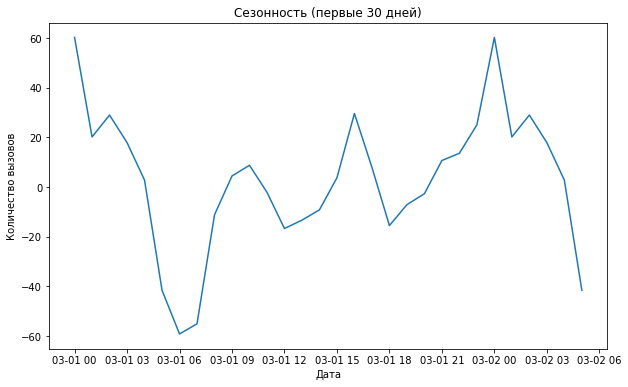

In [9]:
decomposition = seasonal_decompose(df['num_orders'], model='additive')

trend = decomposition.trend
seasonal = decomposition.seasonal
residuals = decomposition.resid

plt.figure(figsize=(10, 6))
plt.plot(trend)
plt.title('Тренд')
plt.xlabel('Дата')
plt.ylabel('Количество вызовов')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(seasonal[:30])
plt.title('Сезонность (первые 30 дней)')
plt.xlabel('Дата')
plt.ylabel('Количество вызовов')
plt.show()

## Обучение

In [10]:
def make(df, max_lag, rolling_mean_size):
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()
    
#make(df, 5, 5)


In [11]:
def make_features(df, max_lag, rolling_mean_size):
    df_copy = df.copy()

    df_copy['year'] = df_copy.index.year
    df_copy['month'] = df_copy.index.month
    df_copy['day'] = df_copy.index.day
    df_copy['dayofweek'] = df_copy.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        df_copy['lag_{}'.format(lag)] = df_copy['num_orders'].shift(lag)

    df_copy['rolling_mean'] = df_copy['num_orders'].shift().rolling(rolling_mean_size).mean()
    
make_features(df, 24, 24)

Для более качественного прогноза добавим признаки в датасет

In [12]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)

train = train.dropna()

Создадим тестовую и тренировочную выборку для дальнейшего исследования

In [13]:
X_train = train.drop('num_orders', axis=1)
y_train = train['num_orders']

X_test = test.drop('num_orders', axis=1)
y_test = test['num_orders']

In [14]:
X_train.isna().sum()

rolling_mean    0
dtype: int64

In [15]:
X_train = X_train.dropna()
LR = LinearRegression() 
LR.fit(X_train, y_train) 
predictions = LR.predict(X_train) 


Для начала попробуем модель линейной регрессии

In [16]:
rmse = np.sqrt(mean_squared_error(y_train, predictions))
print('RMSE равно:', rmse)

RMSE равно: 18.072624180098128


Метрика на тренировочной выборке равна 33.21

In [17]:
model = CatBoostRegressor(random_state=12345, silent=True)

param_grid = {
    'depth': [4, 6, 8],
    'learning_rate': [0.1, 0.01, 0.001],
    'iterations': [100, 200, 300]
}

tsp = TimeSeriesSplit(n_splits=3)
search = GridSearchCV(estimator=model, param_grid=param_grid, cv=tsp, scoring='neg_mean_squared_error')

Рассмотрим вторую модель и подберем для нее оптимальные гиперпараметры, используя GridSearchCV

In [18]:
%%time
search.fit(X_train, y_train)

CPU times: user 10.7 s, sys: 1.27 s, total: 11.9 s
Wall time: 55.7 s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=<catboost.core.CatBoostRegressor object at 0x7fb700021a30>,
             param_grid={'depth': [4, 6, 8], 'iterations': [100, 200, 300],
                         'learning_rate': [0.1, 0.01, 0.001]},
             scoring='neg_mean_squared_error')

In [19]:
print(search.best_params_)

{'depth': 4, 'iterations': 100, 'learning_rate': 0.1}


Обучение заняло почти 3 минуты, после чего можно посмотреть на список оптимальных гиперпараметров и впоследствии применить их для обучения модели

In [20]:
model = CatBoostRegressor(random_state=12345, silent=True, loss_function='RMSE', 
                         depth=4, iterations=100, learning_rate=0.1)

model.fit(X_train, y_train) 

pred = model.predict(X_train)


In [21]:
cat_rmse = np.sqrt(mean_squared_error(y_train, pred))
print('RMSE для CatBoostRegressor:', cat_rmse)

RMSE для CatBoostRegressor: 18.120666335528018


Для модели CatBoostRegressor RMSE составляет 33.02

In [22]:
xgb = xgb.XGBRegressor()
xgb.fit(X_train, y_train) 
pred_xgb = xgb.predict(X_train) 


Далее попробуем модель XGBRegressor

In [23]:
xgb_rmse = np.sqrt(mean_squared_error(y_train, pred_xgb))

In [24]:
print('RMSE для модели XGBRegressor составляет:', xgb_rmse)

Для нее метрика RMSE составила 28.44

## Тестирование

In [ ]:
model_final = xgb.XGBRegressor()
model_final.fit(X_train, y_train) 
final_pred = model_final.predict(X_test) 

In [26]:
final_rmse = np.sqrt(mean_squared_error(y_test, final_pred))

In [27]:
print('RMSE лучшей модели на тестовой выборке равно', final_rmse)

RMSE лучшей модели на тестовой выборке равно 38.02375960725036


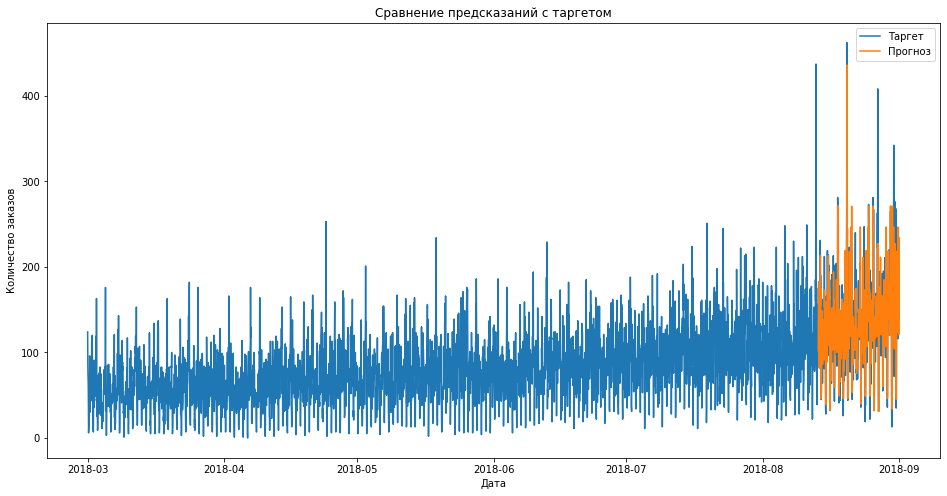

In [28]:
pred_series = pd.Series(final_pred, index=y_test.index)

plt.figure(figsize=(16, 8))
plt.plot(df.index, df['num_orders'], label='Таргет')
plt.plot(pred_series.index, pred_series, label='Прогноз')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.title('Сравнение предсказаний с таргетом')
plt.legend()
plt.show()

В проекте было проанализировано несколько моделей (LinearRegression, CatBoostRegressor, XGBRegressor). Все модели были проанализированы на тренировочной выборке, что позволило выбрать лучшую модель и использовать ее на тестовой выборке. Лучшей моделью оказалась модель XGBRegressor, которая показала результат в 38.02 на тестовой выборке, что ниже требуемого уровня. Таким образом можно заключить, что поставленная задача была выполнена, а именно найдена и обучена модель, которая сможет прогнозировать временной ряд со значением метрики RMSE < 48